 # Model Generation
 ## Imports

In [7]:
import pandas as pd
import numpy as np
# import tensorflow as tf
# from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
        GradientBoostingClassifier, StackingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import label_binarize
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import cross_validate
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split

import scikitplot as skplt


 ## Read in the features

In [8]:
filedata = pd.read_pickle('./output/intermediate-data/filedata-librosaConventionalFeatures.pkl')


 ## Try traditional ML models
 ### Define and train the models

In [9]:
models = [  
    OneVsRestClassifier(LogisticRegression(random_state=1, n_jobs=-1), n_jobs=-1),
    OneVsRestClassifier(KNeighborsClassifier(n_neighbors=10, n_jobs=-1), n_jobs=-1),
    OneVsRestClassifier(DecisionTreeClassifier(), n_jobs=-1),
    OneVsRestClassifier(GaussianNB(), n_jobs=-1),
    OneVsRestClassifier(LinearSVC(), n_jobs=-1),
    OneVsRestClassifier(BaggingClassifier(base_estimator=\
        DecisionTreeClassifier(max_leaf_nodes=2620), n_estimators=100, n_jobs=-1), n_jobs=-1)
]
model_namelist = ['Logistic Regression',
                  'KNeighbors',
                  'Decision Tree',
                  'GaussianNB', 
                  'SVM/Linear SVC',
                  'Bagging-DT'
                  ]
scoring = {'precision': make_scorer(precision_score, average='micro'), 
           'recall': make_scorer(recall_score, average='micro'), 
            'accuracy': make_scorer(accuracy_score), 
           'f1': make_scorer(f1_score, average='micro'),
           'roc_auc': make_scorer(roc_auc_score, average='micro'),
           # 'mcc': make_scorer(matthews_corrcoef) <- cannot support multi-label
          }

cv_result_entries = []
i = 0                  

#this code goes through and separates out each  elements of each feature array into separate columns
# DON'T CHANGE IT
mfccs = pd.DataFrame(filedata['mfccs'].iloc[x] for x in range(len(filedata)))
melSpec = pd.DataFrame(filedata['melSpec'].iloc[x] for x in range(len(filedata)))

#too many elements
#stft = pd.DataFrame(filedata['stft'].iloc[x] for x in range(len(filedata)))
chroma_stft = pd.DataFrame(filedata['chroma_stft'].iloc[x] for x in range(len(filedata)))
spectral_contrast_stft = pd.DataFrame(filedata['spectral_contrast_stft'].iloc[x] for x in range(len(filedata)))
tonnetz = pd.DataFrame(filedata['tonnetz'].iloc[x] for x in range(len(filedata)))

#too many elements, hella big
#visFFT = pd.DataFrame(filedata['visFFT'].iloc[x] for x in range(len(filedata)))

X = pd.concat([mfccs, melSpec, chroma_stft, spectral_contrast_stft, \
    tonnetz], axis=1)

y = label_binarize(
      pd.DataFrame(filedata['classID'].iloc[x] for x in range(len(filedata))),
      classes=[0,1,2,3,4,5,6,7,8,9]
      )

X_train, X_test, y_train, y_test = train_test_split(X, y, \
    test_size=0.20, random_state=0)

# ### Loop cross validation through various models and generate results
for mod in models:
    metrics = cross_validate(
        mod,
        X_train,
        y_train,
        cv=5,
        scoring = scoring,
        return_train_score=False,
        n_jobs=-1
    )
    for key in metrics.keys():
        for fold_index, score in enumerate(metrics[key]):
            cv_result_entries.append((model_namelist[i], fold_index, key, score))
    i += 1
cv_results_df = pd.DataFrame(cv_result_entries)


 ### Misclassification Errors

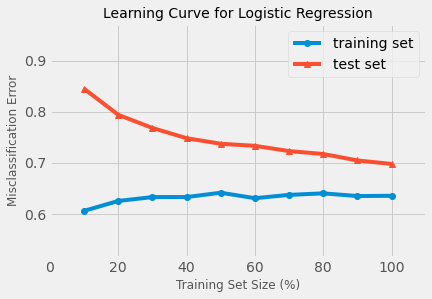

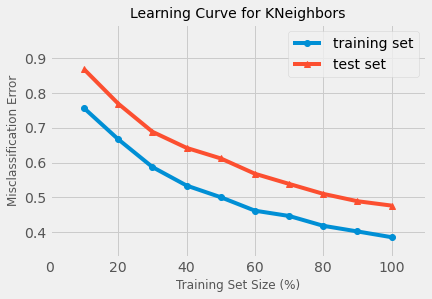

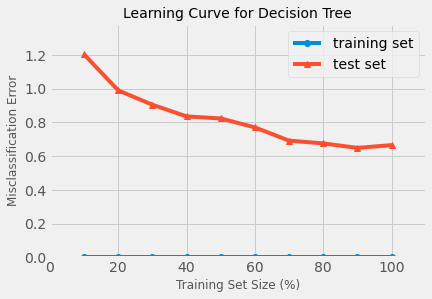

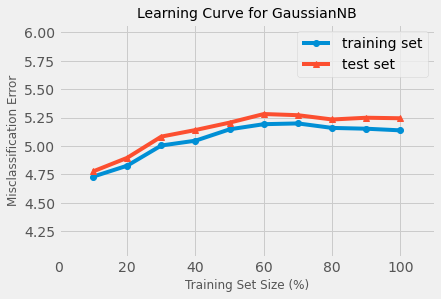

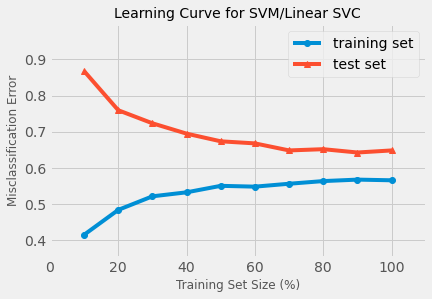

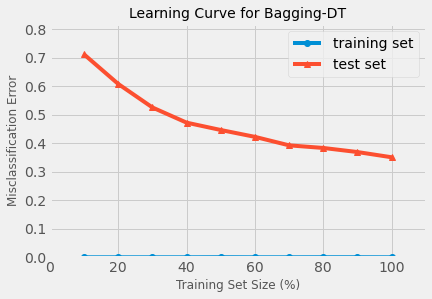

In [10]:
i=0
for model in models:

    plot_learning_curves(X_train, y_train, X_test, y_test, model)
    plt.title('Learning Curve for ' + model_namelist[i], fontsize=14)
    plt.xlabel('Training Set Size (%)', fontsize=12)
    plt.ylabel('Misclassification Error', fontsize=12)
    plt.show()
    i += 1


 ### Get predictions: prep for Confusion Matrix

In [11]:
y_test_pred = []
for model in models:
    y_test_pred.append(model.predict(X_test))



 ### Graph metrics

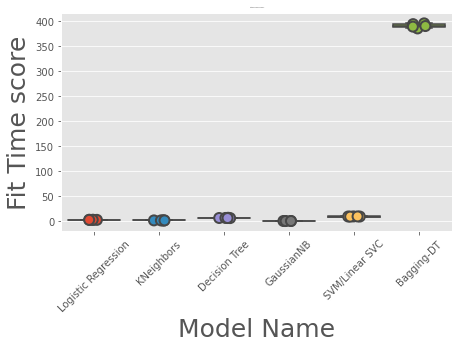

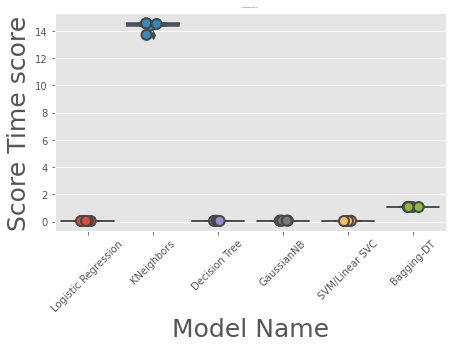

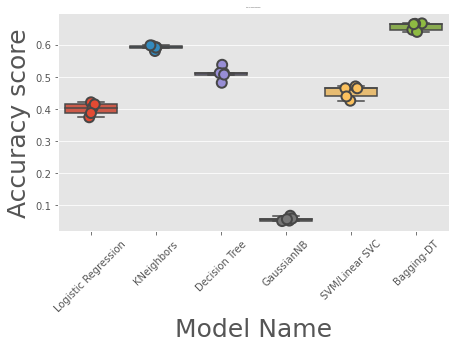

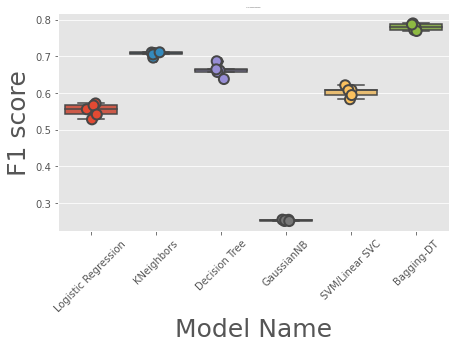

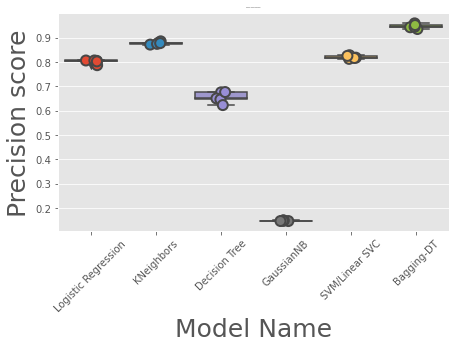

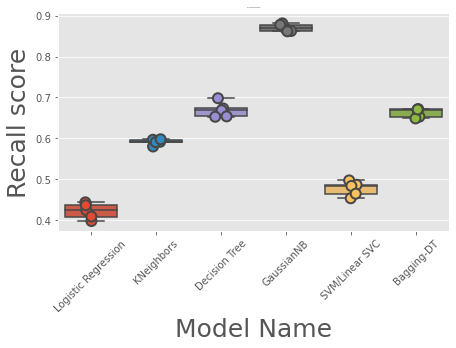

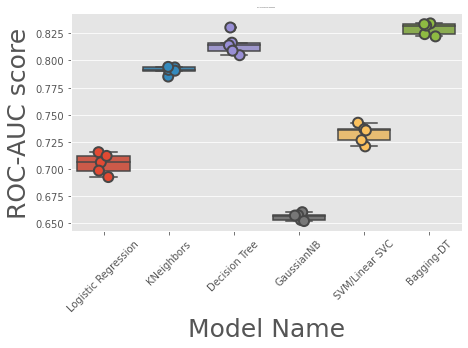

In [26]:
fig_size_tuple = (7, 4)
title_fontsize_num = 0
label_fontsize_num = 25

df_cross_validate_results = pd.DataFrame(cv_result_entries, columns =['model_name', 'fold_index', 'metric_key', 'metric_score'])

df_cv_results_fit_time = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'fit_time']
df_cv_results_score_time = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'score_time']
df_cv_results_accuracy = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_accuracy']
df_cv_results_precision = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_precision']
df_cv_results_recall = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_recall']
df_cv_results_f1 = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_f1']
df_cv_results_f2 = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_f2']
df_cv_results_roc_auc = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_roc_auc']


plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_fit_time)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_fit_time, size=10, linewidth=2)
plt.title('Fit Time Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Fit Time score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_score_time)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_score_time, size=10, linewidth=2)
plt.title('Score Time Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Score Time score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_accuracy)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_accuracy, size=10, linewidth=2)
plt.title('Accuracy Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Accuracy score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_f1)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_f1, size=10, linewidth=2)
plt.title('F1 Score Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('F1 score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

# plt.figure(figsize=fig_size_tuple)
# sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_f2)
# sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_f2, size=10, linewidth=2)
# plt.title('F2 Score Model Comparison', fontsize=title_fontsize_num)
# plt.xlabel('Model Name', fontsize=label_fontsize_num)
# plt.ylabel('F2 score', fontsize=label_fontsize_num)
# plt.xticks(rotation=45)
# plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_precision)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_precision, size=10, linewidth=2)
plt.title('Precision Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Precision score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_recall)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_recall, size=10, linewidth=2)
plt.title('Recall Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Recall score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_roc_auc)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_roc_auc, size=10, linewidth=2)
plt.title('ROC-AUC Score Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('ROC-AUC score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()


 ### Confusion Matrix

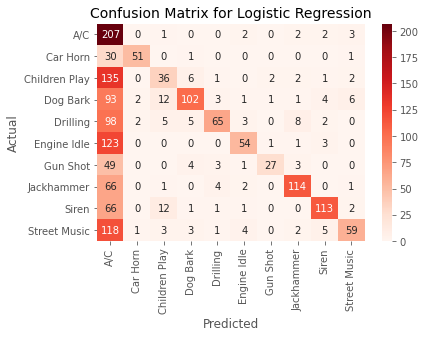

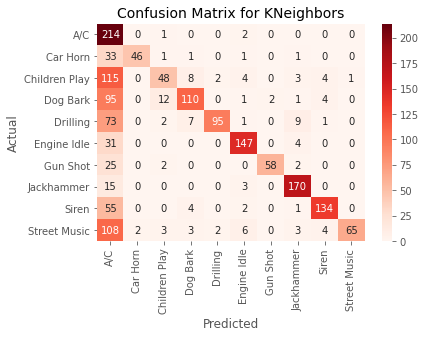

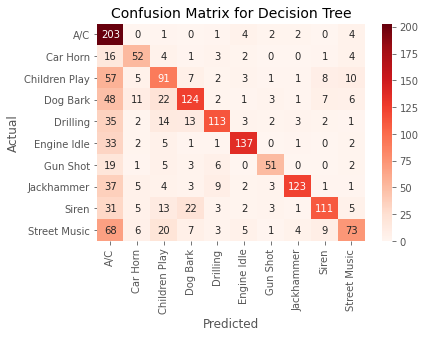

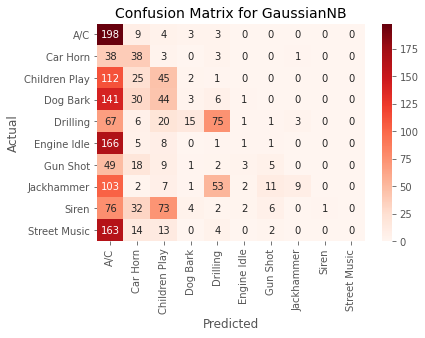

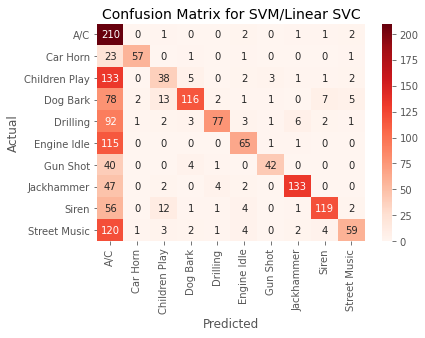

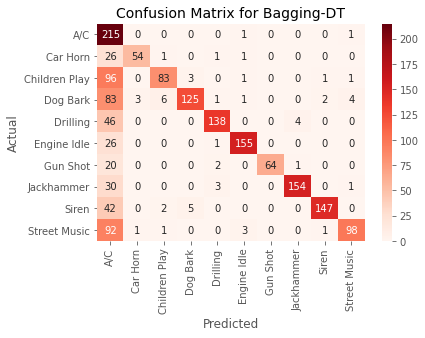

In [13]:
CLASSES = ['A/C', 'Car Horn', 'Children Play', 'Dog Bark',
           'Drilling', 'Engine Idle', 'Gun Shot', 'Jackhammer',
           'Siren', 'Street Music']
i=0
for _ in models:
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_test_pred[i], axis=1))
    cm_df = pd.DataFrame(cm, index = CLASSES, columns = CLASSES)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    plt.title('Confusion Matrix for ' + model_namelist[i], fontsize=14)
    sns.heatmap(cm_df, annot=True, fmt='.6g', annot_kws={"size": 10}, cmap='Reds')
    plt.show()
    i += 1


In [14]:

print(mfccs.shape)
print(melSpec.shape)
print(chroma_stft.shape)
print(spectral_contrast_stft.shape)
print(tonnetz.shape)
#print(visFFT.shape)
print(X.shape)


(8731, 40)
(8731, 128)
(8731, 12)
(8731, 7)
(8731, 6)
(8731, 193)


In [15]:

#Sanity check on SVM test results
# testResults = pd.DataFrame() 
# actual = []
# predict = []
# for x in range(len(y_test)):
#     actual.append(np.argmax(y_test[x])+1)
#     predict.append(np.argmax(y_test_pred[4][x])+1)

# testResults['actual'] = actual
# testResults['predict'] = predict

# testResults.head()

# testResults.to_csv('testResults')
